In [1]:
# Cell 1: Setup
import sys
sys.path.append('..')

from pathlib import Path
import pandas as pd
import json
import matplotlib.pyplot as plt

from src.data.preprocess import merge_datasets, organize_data, compute_normalization_stats

print("✅ Setup OK")


✅ Setup OK


In [2]:
# Cell 2: Step 1 - Merge
df = merge_datasets('data/raw', 'data/metadata/merged_labels.csv')

print(f"\n✅ Total: {len(df):,}")
df.head()

📊 STEP 1: MERGING DATASETS

🦠 Processing COVID-19 dataset...

  test:
    COVID19         → COVID-19       :   116 images
    NORMAL          → Normal         :   317 images
    PNEUMONIA       → Pneumonia      :   855 images

  train:
    COVID19         → COVID-19       :   460 images
    NORMAL          → Normal         :  1266 images
    PNEUMONIA       → Pneumonia      :  3418 images

🫁 Processing Tuberculosis dataset...
  Normal          → Normal         :  3500 images
  Tuberculosis    → Tuberculosis   :   700 images

🤒 Processing Pneumonia dataset...

  train:
    NORMAL          → Normal         :  1341 images
    PNEUMONIA       → Pneumonia      :  3875 images

  test:
    NORMAL          → Normal         :   234 images
    PNEUMONIA       → Pneumonia      :   390 images

  val:
    NORMAL          → Normal         :     8 images
    PNEUMONIA       → Pneumonia      :     8 images

✅ MERGE COMPLETE!
Total images: 16,488
Saved to: data/metadata/merged_labels.csv

📊 Class Distr

,image_path,label,source_dataset
0,/home/ducluong/chest-xray-classification/data/...,COVID-19,covid19
1,/home/ducluong/chest-xray-classification/data/...,COVID-19,covid19
2,/home/ducluong/chest-xray-classification/data/...,COVID-19,covid19
3,/home/ducluong/chest-xray-classification/data/...,COVID-19,covid19
4,/home/ducluong/chest-xray-classification/data/...,COVID-19,covid19



📊 CLASS DISTRIBUTION:
label
COVID-19         576
Normal          6666
Pneumonia       8546
Tuberculosis     700
Name: count, dtype: int64

📦 SOURCE DISTRIBUTION:
source_dataset
covid19         6432
pneumonia       5856
tuberculosis    4200
Name: count, dtype: int64


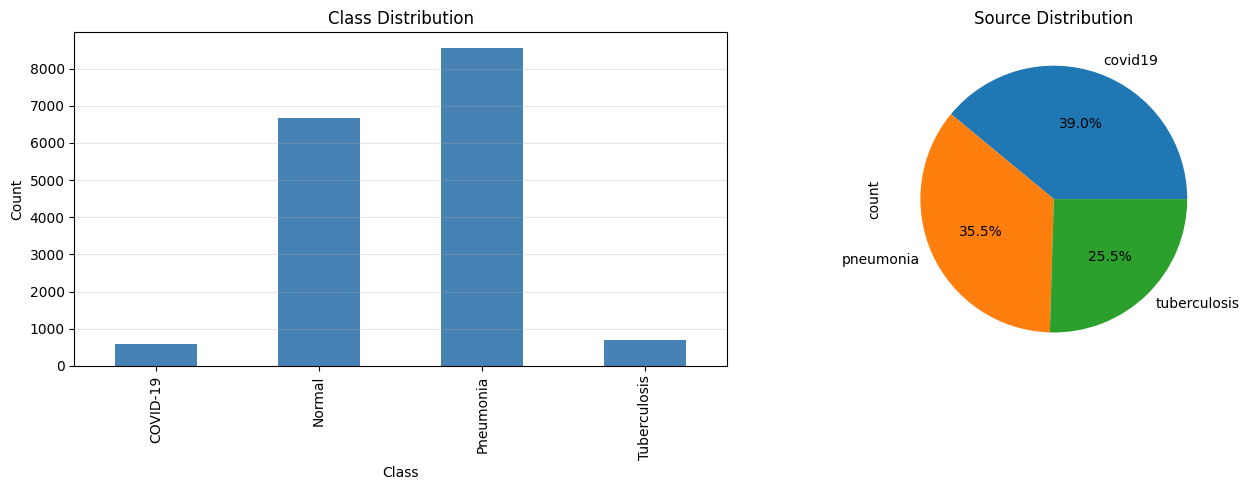

In [4]:
# Cell 3: Analyze merged data
print("\n📊 CLASS DISTRIBUTION:")
print(df['label'].value_counts().sort_index())

print("\n📦 SOURCE DISTRIBUTION:")
print(df['source_dataset'].value_counts())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

df['label'].value_counts().sort_index().plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Class Distribution')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.grid(axis='y', alpha=0.3)

df['source_dataset'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Source Distribution')

plt.tight_layout()
plt.show()

In [5]:
# Cell 4: Step 2 - Organize
split_summary = organize_data(
    'data/metadata/merged_labels.csv',
    'data/processed',
    train_ratio=0.70,
    val_ratio=0.15,
    test_ratio=0.15,
    random_seed=42
)


📁 STEP 2: ORGANIZING DATA

Total images: 16,488

🔀 Performing stratified split...

  COVID-19:
    Total: 576 | Train: 404 | Val: 86 | Test: 86



  Normal:
    Total: 6,666 | Train: 4,668 | Val: 999 | Test: 999



  Pneumonia:
    Total: 8,546 | Train: 5,984 | Val: 1,281 | Test: 1,281



  Tuberculosis:
    Total: 700 | Train: 490 | Val: 105 | Test: 105



✅ ORGANIZATION COMPLETE!

TRAIN: 11,546 images
  COVID-19       :   404 ( 3.50%)
  Normal         :  4668 (40.43%)
  Pneumonia      :  5984 (51.83%)
  Tuberculosis   :   490 ( 4.24%)

VAL: 2,471 images
  COVID-19       :    86 ( 3.48%)
  Normal         :   999 (40.43%)
  Pneumonia      :  1281 (51.84%)
  Tuberculosis   :   105 ( 4.25%)

TEST: 2,471 images
  COVID-19       :    86 ( 3.48%)
  Normal         :   999 (40.43%)
  Pneumonia      :  1281 (51.84%)
  Tuberculosis   :   105 ( 4.25%)

💾 Saved: data/processed/split_summary.json



📊 SPLIT VERIFICATION:


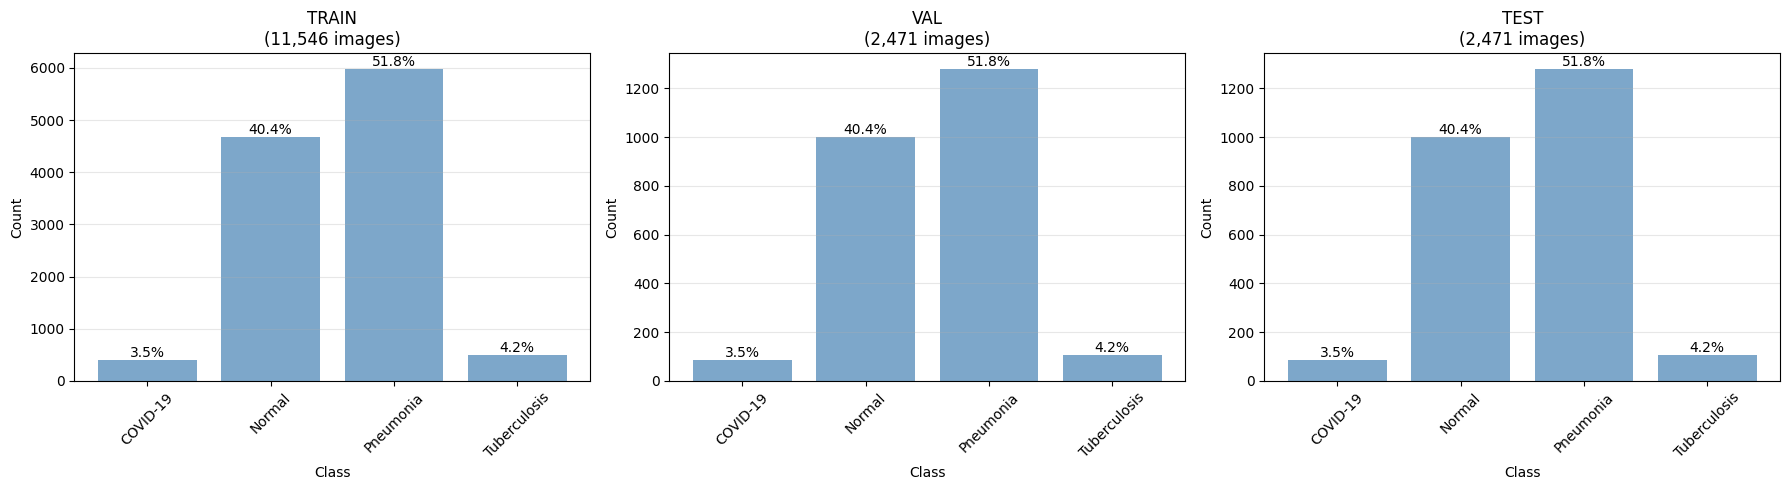


🎯 CLASS BALANCE (% per split):
              Train    Val   Test
COVID-19       3.50   3.48   3.48
Normal        40.43  40.43  40.43
Pneumonia     51.83  51.84  51.84
Tuberculosis   4.24   4.25   4.25

✅ Percentages similar → stratified split successful


In [6]:
# Cell 5: Verify splits
with open('data/processed/split_summary.json') as f:
    summary = json.load(f)

print("\n📊 SPLIT VERIFICATION:")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, split in enumerate(['train', 'val', 'test']):
    classes = sorted(summary[split].keys())
    counts = [summary[split][c] for c in classes]
    
    axes[idx].bar(classes, counts, color='steelblue', alpha=0.7)
    axes[idx].set_title(f'{split.upper()}\n({sum(counts):,} images)')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)
    
    for i, (c, count) in enumerate(zip(classes, counts)):
        pct = count/sum(counts)*100
        axes[idx].text(i, count, f'{pct:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Class balance check
print("\n🎯 CLASS BALANCE (% per split):")
balance = pd.DataFrame({
    'Train': [summary['train'][c]/sum(summary['train'].values())*100 for c in sorted(summary['train'].keys())],
    'Val': [summary['val'][c]/sum(summary['val'].values())*100 for c in sorted(summary['val'].keys())],
    'Test': [summary['test'][c]/sum(summary['test'].values())*100 for c in sorted(summary['test'].keys())]
}, index=sorted(summary['train'].keys()))

print(balance.round(2))
print("\n✅ Percentages similar → stratified split successful")

In [7]:
# Cell 6: Step 3 - Normalization stats
stats = compute_normalization_stats(
    'data/processed/train',
    sample_size=1000,
    target_size=(512, 512),
    output_file='data/metadata/normalization_stats.json'
)


📐 STEP 3: COMPUTING NORMALIZATION STATS

Total training images: 11,546
Sampling 1000 images...


Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.20it/s]


✅ STATS COMPUTED!
Mean: [0.4909, 0.4930, 0.4941]
Std:  [0.2407, 0.2408, 0.2414]

💾 Saved: data/metadata/normalization_stats.json



Mean: [0.4908561706542969, 0.49303561449050903, 0.4940687119960785]
Std:  [0.2407049834728241, 0.24082882702350616, 0.24142147600650787]


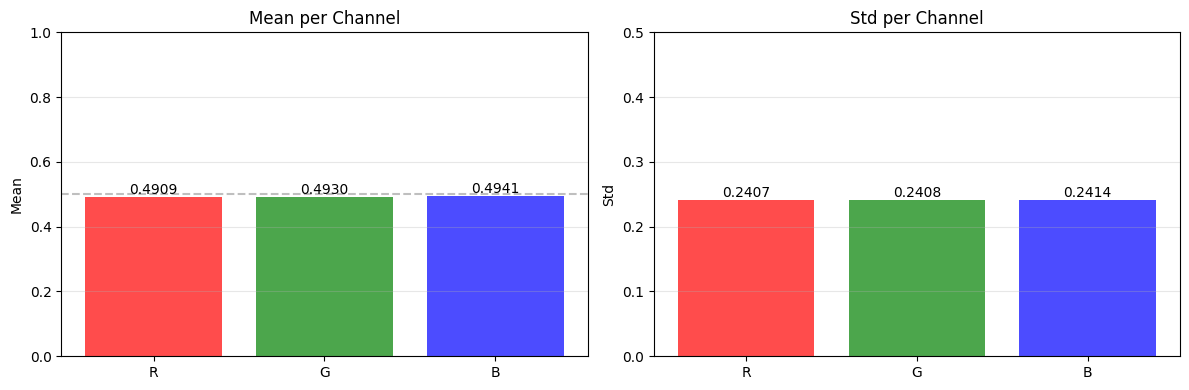


💡 Mean values similar → grayscale-like (X-ray)
   Avg brightness: 0.4927


In [8]:
# Cell 7: Analyze stats
with open('data/metadata/normalization_stats.json') as f:
    stats = json.load(f)

mean, std = stats['mean'], stats['std']

print(f"\nMean: {mean}")
print(f"Std:  {std}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

channels = ['R', 'G', 'B']
colors = ['red', 'green', 'blue']

ax1.bar(channels, mean, color=colors, alpha=0.7)
ax1.set_title('Mean per Channel')
ax1.set_ylabel('Mean')
ax1.set_ylim([0, 1])
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax1.grid(axis='y', alpha=0.3)

for i, v in enumerate(mean):
    ax1.text(i, v, f'{v:.4f}', ha='center', va='bottom')

ax2.bar(channels, std, color=colors, alpha=0.7)
ax2.set_title('Std per Channel')
ax2.set_ylabel('Std')
ax2.set_ylim([0, 0.5])
ax2.grid(axis='y', alpha=0.3)

for i, v in enumerate(std):
    ax2.text(i, v, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n💡 Mean values similar → grayscale-like (X-ray)")
print(f"   Avg brightness: {sum(mean)/3:.4f}")

In [9]:
# Cell 8: Summary
print("\n" + "=" * 70)
print("🎉 PREPROCESSING COMPLETE!")
print("=" * 70)

print("\n✅ Output:")
print("  data/metadata/")
print("    ├── merged_labels.csv")
print("    └── normalization_stats.json")
print("  data/processed/")
print("    ├── train/")
print("    ├── val/")
print("    ├── test/")
print("    └── split_summary.json")

print(f"\n📊 Summary:")
print(f"  Total: {len(df):,} images")
print(f"  Classes: {len(df['label'].unique())}")
print(f"  Train: {sum(summary['train'].values()):,}")
print(f"  Val:   {sum(summary['val'].values()):,}")
print(f"  Test:  {sum(summary['test'].values()):,}")

print(f"\n📐 Normalization:")
print(f"  Mean: {mean}")
print(f"  Std:  {std}")

print("\n🚀 Ready for next: 03_test_dataloader.ipynb")


🎉 PREPROCESSING COMPLETE!

✅ Output:
  data/metadata/
    ├── merged_labels.csv
    └── normalization_stats.json
  data/processed/
    ├── train/
    ├── val/
    ├── test/
    └── split_summary.json

📊 Summary:
  Total: 16,488 images
  Classes: 4
  Train: 11,546
  Val:   2,471
  Test:  2,471

📐 Normalization:
  Mean: [0.4908561706542969, 0.49303561449050903, 0.4940687119960785]
  Std:  [0.2407049834728241, 0.24082882702350616, 0.24142147600650787]

🚀 Ready for next: 03_test_dataloader.ipynb
